<a href="https://colab.research.google.com/github/Mohammad-H-Zahrawi/Projects/blob/main/X-ray%20Implant%20Identification/Albumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Data

If the code is not working properly, uncomment the next two comments

In [ ]:
# pip uninstall opencv-python-headless==4.5.5.62

In [ ]:
# pip install opencv-python-headless==4.5.2.52

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pathlib
import random
import matplotlib.image as mpimg
import os
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive/Implant_data/train

Isola  Legacy  M8M10  Reline  Viper  Xia


In [ ]:
cd /content/drive/MyDrive

/content/drive/MyDrive


# Albumentation

In [ ]:
pip install -U albumentations

In [ ]:
import albumentations as A
import cv2

# Declare an augmentation pipeline
transform = A.Compose([
        A.RandomRotate90(),
        A.Flip(),
        A.Transpose(),
        A.OneOf([
            A.IAAAdditiveGaussianNoise(),
            A.GaussNoise(),
        ], p=0.2),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.2),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.IAAPiecewiseAffine(p=0.3),
        ], p=0.2),
        A.OneOf([
            
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

# Read an image with OpenCV and convert it to the RGB colorspace
image = cv2.imread("/content/drive/MyDrive/Implant_data/train/Isola/facebook_2330_AP.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]

/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:290: FutureWarning: This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead
  warnings.warn("This IAAPiecewiseAffine is deprecated. Please use PiecewiseAffine instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.7/dist-packages/albumentations/imgaug/transforms.py:165: FutureWarning: This augmentation is deprecated. Please use Emboss instead
  warnings.warn("This augmentation is deprecated. Please use Embo

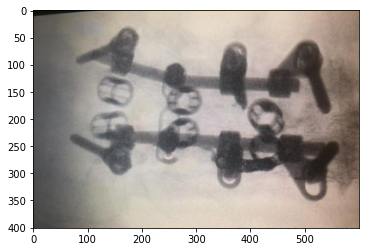

In [ ]:
plt.imshow(transformed_image)

In order to rum next cell, follow the instructions:


*   create folder with name 'Implant_data_album'.
*   create six subfolders inside 'Implant_data_album'
*   save new augmented images into each subfolers
*   download them on desktop, merge them with original data.
*   upload them again



In [ ]:
for clas in os.listdir('/content/drive/MyDrive/Implant_data/train/'):
  for i in os.listdir('/content/drive/MyDrive/Implant_data/train/'+clas):
    img = mpimg.imread('/content/drive/MyDrive/Implant_data/train/'+clas+'/'+i)
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed = transform(image=image)
    transformed_image = transformed["image"]

    cv2.imwrite('/content/drive/MyDrive/Implant_data_album/train/'+clas+'/'+i+'.jpg',img)

## models using albumentations

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.random.set_seed(42)
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Setup the train and test directories
train_dir = '/content/drive/MyDrive/Implant_data_aug2/train'
test_dir = 'Implant_data/test'

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(128,128),
                                               color_mode='rgb',class_mode="categorical",shuffle=True)

valid_data = train_datagen.flow_from_directory(test_dir,batch_size=32,target_size=(128,128),
                                               color_mode='rgb',class_mode="categorical",shuffle=True)

Found 1106 images belonging to 6 classes.
Found 114 images belonging to 6 classes.


In [ ]:
# Create a CNN model
model_1 = tf.keras.models.Sequential([
                                      tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu',input_shape=(128,128,3)),
                                      tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2,padding='valid'),
                                      tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                                      tf.keras.layers.Conv2D(filters=10,kernel_size=3,activation='relu'),
                                      tf.keras.layers.MaxPool2D(pool_size=2),
                                      tf.keras.layers.Flatten(),
                                      tf.keras.layers.Dense(6,activation='sigmoid')
])


model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(),
                 metrics=['accuracy'])

history_1 = model_1.fit(train_data,epochs=8,steps_per_epoch=len(train_data),validation_data=valid_data,validation_steps=len(valid_data),shuffle=True)

Epoch 1/8
35/35 [==============================] - 409s 11s/step - loss: 1.7424 - accuracy: 0.2559 - val_loss: 1.7169 - val_accuracy: 0.3158
Epoch 2/8
35/35 [==============================] - 5s 155ms/step - loss: 1.6639 - accuracy: 0.2957 - val_loss: 1.6133 - val_accuracy: 0.2719
Epoch 3/8
35/35 [==============================] - 5s 156ms/step - loss: 1.4964 - accuracy: 0.3942 - val_loss: 1.6117 - val_accuracy: 0.3509
Epoch 4/8
35/35 [==============================] - 5s 156ms/step - loss: 1.2006 - accuracy: 0.5506 - val_loss: 1.7878 - val_accuracy: 0.2807
Epoch 5/8
35/35 [==============================] - 5s 155ms/step - loss: 0.7948 - accuracy: 0.7405 - val_loss: 2.5326 - val_accuracy: 0.2456
Epoch 6/8
35/35 [==============================] - 5s 157ms/step - loss: 0.4877 - accuracy: 0.8336 - val_loss: 2.4560 - val_accuracy: 0.2544
Epoch 7/8
35/35 [==============================] - 5s 157ms/step - loss: 0.2774 - accuracy: 0.9222 - val_loss: 3.8949 - val_accuracy: 0.2632
Epoch 8/8
35/

## FastAi

In [ ]:
!pip install fastai --upgrade

In [ ]:
!pip install fastai==2.2.5


      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: fastai
    Found existing installation: fastai 2.5.3
    Uninstalling fastai-2.5.3:
      Successfully uninstalled fastai-2.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.7.1 which is incompatible.


In [ ]:
from fastai.vision.all import *

In [ ]:
def to_grayscale(img):
  return img.convert('L')

class GreyScaleTfm(Transform):
  def encodes(self, img: Image.Image):
    return to_grayscale(img)

img_size = 224

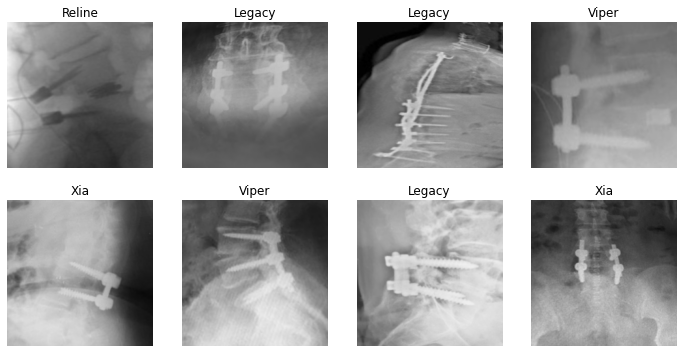

In [ ]:
str='/content/drive/MyDrive/Implant_data_aug2/'
p = Path(str)
dls = ImageDataLoaders.from_folder(p, train='train', valid='test',  bs=8, item_tfms=[GreyScaleTfm(order=0), Resize(img_size, method='squish', order=1)],batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
files = get_image_files(p)
len(files)
dls.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)
learn.fine_tune(50)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.542785,2.750192,0.298246,00:53


epoch,train_loss,valid_loss,accuracy,time
0,1.742075,2.488472,0.315789,00:21
1,1.398483,2.389981,0.298246,00:21
2,1.183434,2.883537,0.307018,00:21
3,1.020187,2.754234,0.324561,00:23
4,0.868461,3.160704,0.324561,00:22
5,0.801251,2.936377,0.333333,00:21
6,0.800192,3.458061,0.333333,00:21
7,0.824637,4.008347,0.333333,00:21
8,0.735137,3.015899,0.324561,00:21
9,0.679611,3.516926,0.368421,00:21


Test accuracy

In [ ]:
testFolder='/content/drive/MyDrive/Implant_data_aug/test/'
files = get_image_files(testFolder)
files

(#114) [Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/image003_test222.jpg'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/img_5772.jpg'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/expedium_ pmc3170270_1.png'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/spinal_xray_789__ML.jpg'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/facebook_7473_ML.jpg'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/viper_ pmc3809439_1.png'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/spinal_xray_81_ML.jpg'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/image002_test_209.png'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/expedium_xray3.png'),Path('/content/drive/MyDrive/Implant_data_aug/test/Viper/facebook_4737_ML.jpg')...]

In [ ]:
counter=0
correct=0
for i in os.listdir('/content/drive/MyDrive/Implant_data_aug/test'):
  for j in os.listdir('/content/drive/MyDrive/Implant_data_aug/test/'+i):
    counter=counter+1
    p=learn.predict('/content/drive/MyDrive/Implant_data_aug/test/'+i+'/'+j)
    if p[0]==i:
      correct=correct+1
print('the accuracy of the model is:',correct/counter) 

the accuracy of the model is: 0.4473684210526316
